# PyTorch🔥MNIST GAN Linear

Subject: Building a GAN (Generative Adversarial Network) with PyTorch to generate hand-written digits from noise, trained from MNIS dataset.

Data: MNIST (handwritten digits) via torchvision

Procedure:
- Previewing images from dataset with pyplot's imshow()
- Generator network with torch.nn.module, torch.nn.Sequential, torch.nn.Linear, torch.nn.Sigmoid, torch.nn.Linear, torch.nn.BatchNorm1d, torch.nn.LeakyReLU, and torch.nn.Dropout
- Discriminator with torch.nn.module, torch.nn.Sequential, torch.nn.Linear, and torch.nn.LeakyReLU,
- Visualizing generator and discriminator with torchviz' make_dot()
- Training with nn.BCEWithLogitsLoss as loss and two torch.optim.Adam optimizers (one for both generator and discriminator)
- Previewing generated digits with imshow() after each n training steps
- Visualization Loss for generator and discriminator with pyplot
- Display development of generated images during training as image show with matplotlib.animation.ArtistAnimation
- Interesting results

Others:
- CUDA support

Sources used:
- todo

## Bootstrap and Imports

In [1]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {DEVICE}')

if IN_COLAB := 'google.colab' in str(get_ipython()):
  NUM_EPOCHS = 100
  !pip install torchviz

else:
  NUM_EPOCHS = 2

Running on cuda
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=2287ff1c5b1addb843f934807b861199ac67572e7703147a42a02d19618f8511
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
from __future__ import print_function
import random
import time
from collections.abc import Callable

import numpy as np
from tqdm.auto import tqdm

from IPython.display import HTML, Image

import matplotlib.animation as animation
import matplotlib.pyplot as plt
#%matplotlib inline

import torch
from torch import nn
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid
from torchvision import utils
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss
from torchviz import make_dot

my_seed = 123
random.seed(my_seed)
torch.manual_seed(my_seed)
np.random.seed(my_seed)

In [3]:
def get_describe_only_once() -> Callable:
    already_described = set()

    def _describe_only_once(tensor: torch.Tensor, name: str):
        if name in already_described:
            return
        already_described.add(name)
        if hasattr(tensor, 'shape'):
            print(f"{name} is a {type(tensor)} of size {tensor.shape}.")
        else:
            print(f"{name} is a {type(tensor)} with content {tensor}.")
    return _describe_only_once

describe_only_once = get_describe_only_once()

## Dataset

In [4]:
BATCH_SIZE = 128
Z_DIM = 64  # dimension of the noise vector
CHANNELS = 1

# 28x28 is the original size; visualization works best with 28x28
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH], antialias=True)
])

# download and save mnist at ./_temp
data_train = datasets.MNIST('./_temp', download=True, train=True, transform=transform)  # data_train.data: <class 'torch.Tensor'> of size torch.Size([60000, 28, 28]).
train_loader = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 455399652.16it/s]


Extracting ./_temp/MNIST/raw/train-images-idx3-ubyte.gz to ./_temp/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 121500194.41it/s]

Extracting ./_temp/MNIST/raw/train-labels-idx1-ubyte.gz to ./_temp/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 222304448.62it/s]


Extracting ./_temp/MNIST/raw/t10k-images-idx3-ubyte.gz to ./_temp/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5858096.18it/s]


Extracting ./_temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./_temp/MNIST/raw



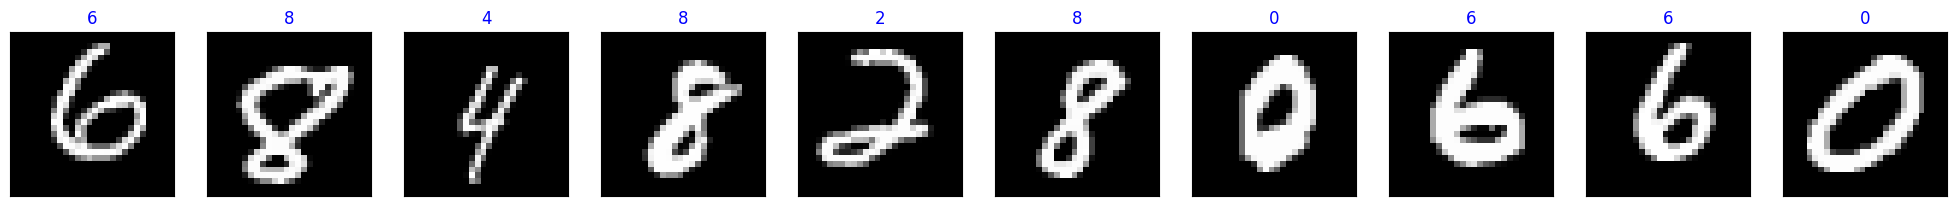

In [6]:
# print some random mnist images
classes = ['0','1','2','3','4','5','6','7','8','9']

dataiter = iter(train_loader)
images, labels = next(dataiter)            # images: <class 'torch.Tensor'> of size torch.Size([128, 1, 28, 28])
                                           # labels: <class 'torch.Tensor'> of size torch.Size([128])

fig = plt.figure(figsize=(25, 10))  # (width, height) in inches

for i in range(10):
    ax = fig.add_subplot(1,         # nrows
                         10,        # ncols
                         i+1,       # index (1-based)
                         xticks=[],
                         yticks=[])
    image = images[i]                               # <class 'torch.Tensor'> of size torch.Size([1, 28, 28]).
    # image_numpy_squeezed = image.numpy().squeeze()  # <class 'numpy.ndarray'> of size (28, 28)  # conversion to ndarry not required(anymore).
    label = labels[i]                               # <class 'torch.Tensor'> of size torch.Size([])
    label_item = label.item()                       # <class 'int'> with content e.g. 3
    ax.imshow(X=image.squeeze(),
              cmap='gray')
    ax.set_title(f"{classes[label_item]}", color=("blue"))

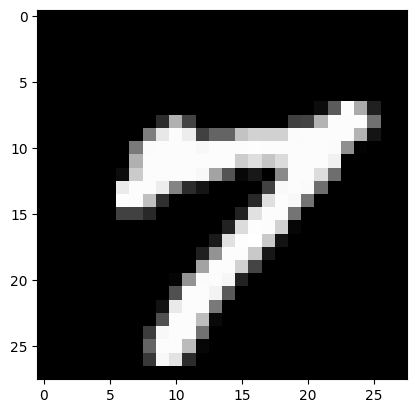

In [7]:
# plot an individual image
image_flat = random.choice(images).squeeze() #  [1, 28, 28] to [28, 28]
plt.imshow(image_flat, cmap='gray')

## Generator
Generator training requires tighter integration between the generator and the discriminator than discriminator training requires. The portion of the GAN that trains the generator includes:
- random input
- generator network, which transforms the random input into a data instance
- discriminator network, which classifies the generated data
- discriminator output
- generator loss, which penalizes the generator for failing to fool the discriminatorinator

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=64, img_dim=IMAGE_HEIGHT*IMAGE_WIDTH, hidden_dim=128):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            self._get_generator_block(z_dim, hidden_dim),  # 64x128
            self._get_generator_block(hidden_dim, hidden_dim * 2),  # 128x256
            self._get_generator_block(hidden_dim * 2, hidden_dim * 4),  # 256x512
            self._get_generator_block(hidden_dim * 4, hidden_dim * 8),  # 512x1024
            nn.Linear(hidden_dim * 8, img_dim),  # 1024x784
            nn.Sigmoid(),  # 784x784
        )

    def _get_generator_block(self, input_dim: int, output_dim: int) -> nn.Sequential:
        seq = nn.Sequential(
          nn.Linear(in_features=input_dim, out_features=output_dim),  # fully-connected
          nn.BatchNorm1d(num_features=output_dim),  # normalize to N~(0, 1), i.e. mean of 0 and standard deviation of 1
          nn.LeakyReLU(negative_slope=0.2, inplace=False),
          nn.Dropout(p=0.3, inplace=False),  # randomly zeroes some of the elements of the input tensor
        )
        return seq

    def forward(self, noise) -> torch.Tensor:  # noise: [128, 64]
        generator_output = self.layers(noise)   # [128, 784]
        return generator_output

In [9]:
# generate random noise as generator input
def get_generator_noise(n_sample: int, z_dim: int, device=DEVICE):
  my_noise = torch.randn(n_sample, z_dim, device=device)
  return my_noise  # [128, 64]


some_noise = get_generator_noise(n_sample=BATCH_SIZE,  # [128, 64]
                                 z_dim=Z_DIM)

generator_output is a <class 'torch.Tensor'> of size torch.Size([128, 784])


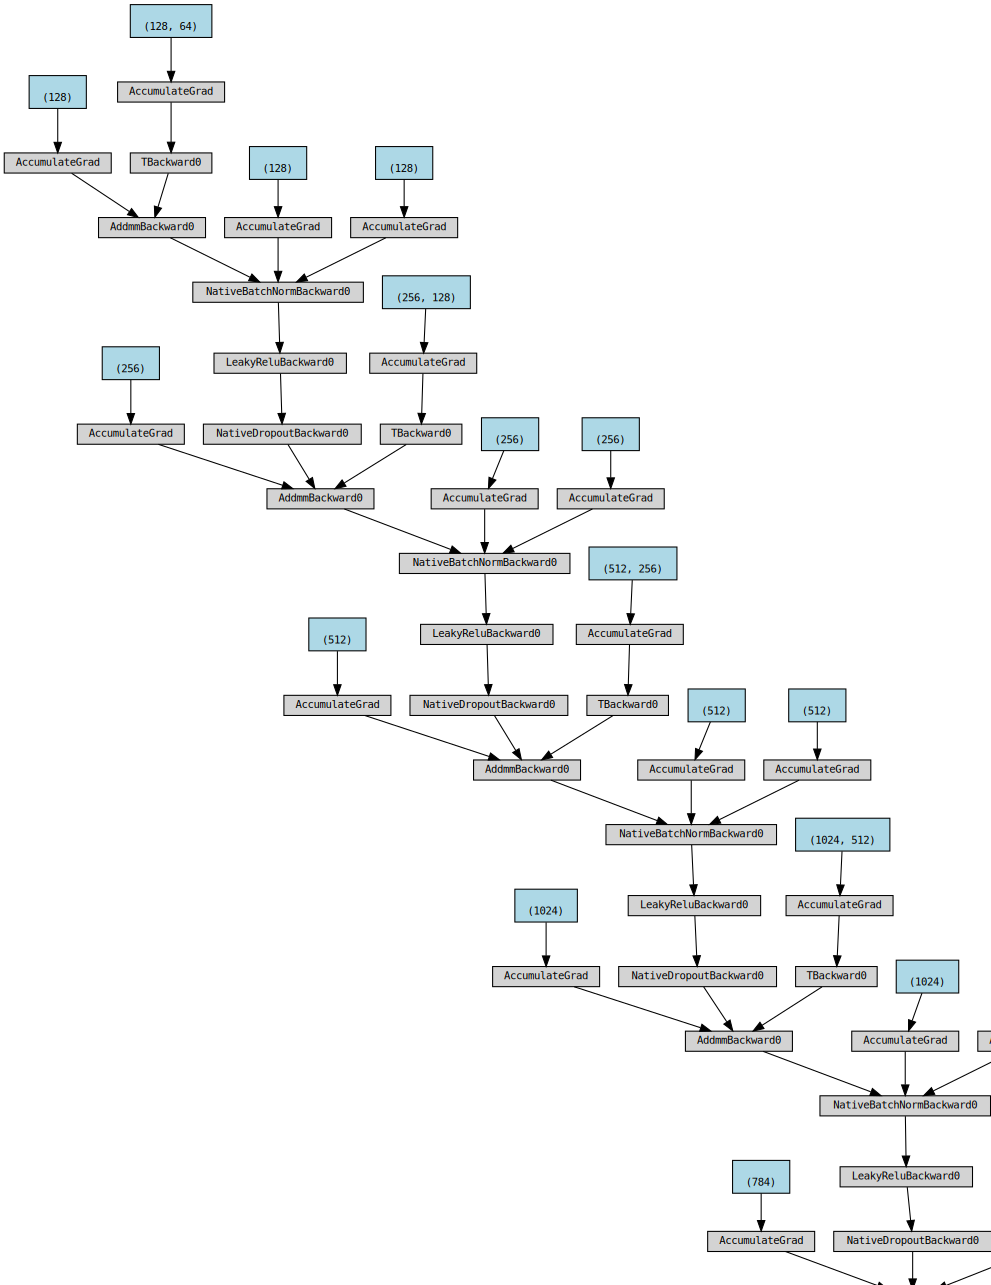

In [10]:
# visualize the Generator
g_temp = Generator(z_dim=Z_DIM).to(DEVICE)
# to visualize with torchviz, we need a dummy input that can pass through the model's forward() method.
generator_output = g_temp(some_noise)
print(f"generator_output is a {type(generator_output)} of size {generator_output.shape}")
make_dot(generator_output)

## Discriminator
The discriminator in a GAN is simply a classifier. It tries to distinguish real data from the data created by the generator. It could use any network architecture appropriate to the type of data it's classifying.

The discriminator's training data comes from two sources:

- Real data instances, such as real pictures of people. The discriminator uses these instances as positive examples during training.
- Fake data instances created by the generator. The discriminator uses these instances as negative examples during training.

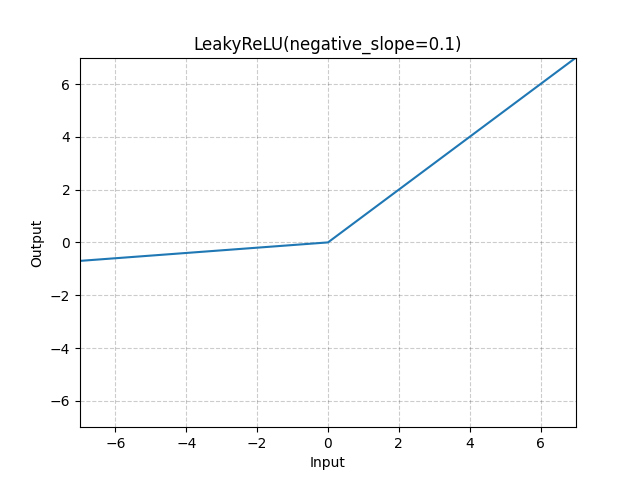

In [11]:
Image("https://pytorch.org/docs/stable/_images/LeakyReLU.png")

In [12]:
class Discriminator(nn.Module):
    def __init__(self, img_dim=IMAGE_HEIGHT * IMAGE_WIDTH, hidden_dim=128):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            self._get_discriminator_block(img_dim, hidden_dim * 4),  # 784x512
            self._get_discriminator_block(hidden_dim * 4, hidden_dim * 2),  # 512x256
            self._get_discriminator_block(hidden_dim * 2, hidden_dim),  # 256x128
            nn.Linear(hidden_dim, 1),  # 128x1
        )

    def _get_discriminator_block(self, input_dim: int, output_dim: int) -> nn.Sequential:
      seq = nn.Sequential(
          nn.Linear(input_dim, output_dim),  # fully-connected
          nn.LeakyReLU(negative_slope=0.2, inplace=False),
      )
      return seq

    def forward(self, image: torch.Tensor) -> torch.Tensor:  # image: [128, 784]
        state = self.layers(image)  # [128, 1]
        return state

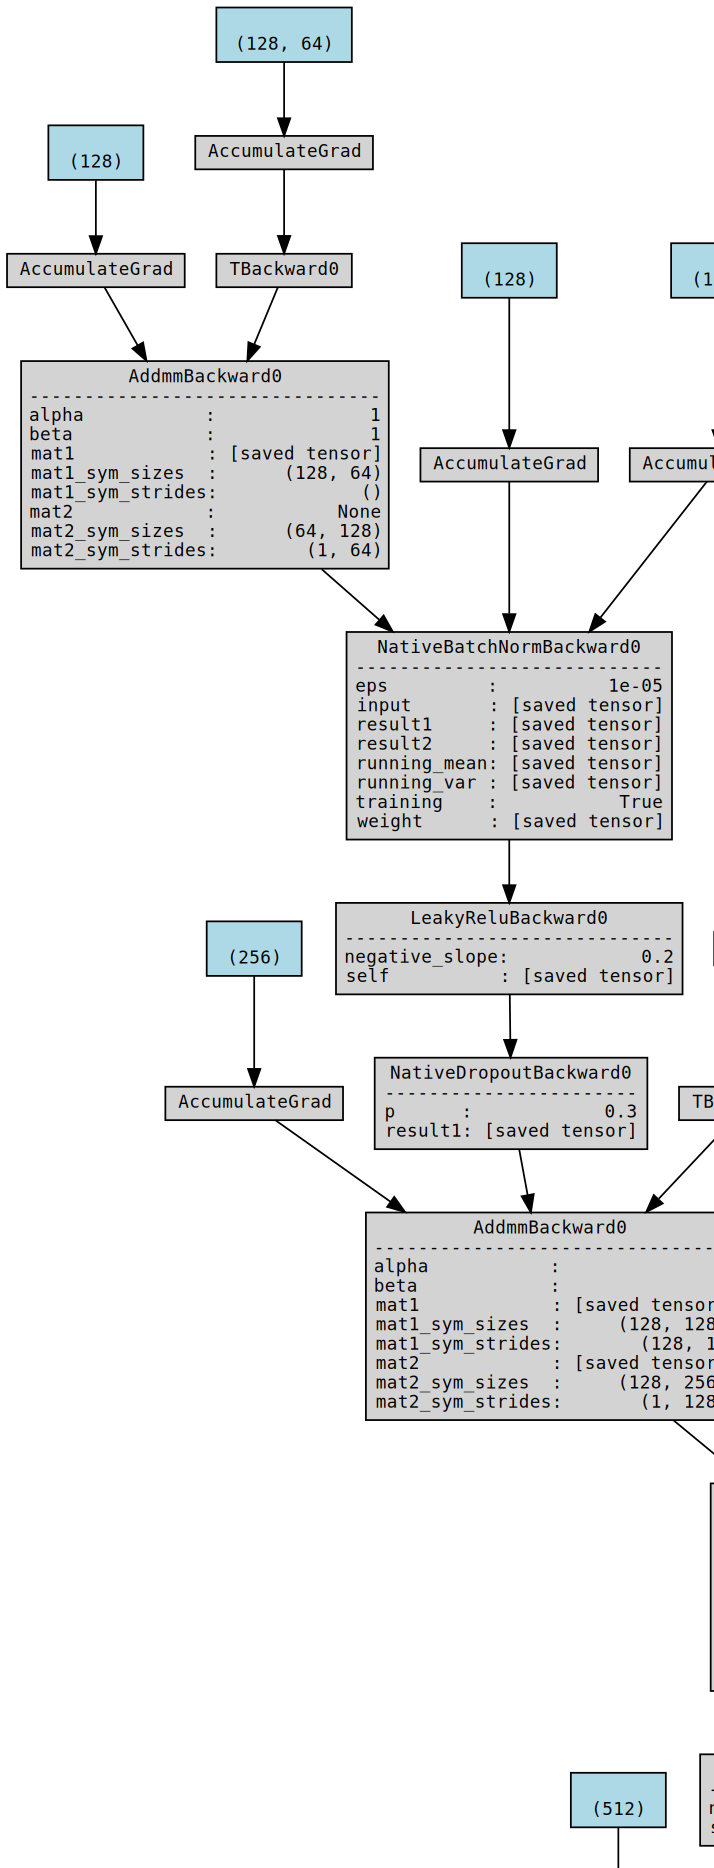

In [13]:
# visualize the Discriminator
d_temp = Discriminator().to(DEVICE)
# to visualize with torchviz, we use the dummy Generator output as dummy input.
discriminator_output = d_temp(generator_output)  # [128, 1]
make_dot(discriminator_output, show_attrs=True)  # show_saved=True)   , params=dict(d_temp.named_parameters()))

## Training
Because a GAN contains two separately trained networks, its training algorithm must address two complications:

- GANs must juggle two different kinds of training (generator and discriminator
-
GAN convergence is hard to identify.

In [14]:
criterion = nn.BCEWithLogitsLoss()
Z_DIM = 64  # dimension of the noise vector
LEARNING_RATE = 0.0001

IMAGE_SIZE = (1, 28, 28)

In [15]:
def get_generator_loss(discriminator: Discriminator,
                       criterion: _Loss,
                       fake_images_flat: torch.Tensor):  # <class 'torch.Tensor'> of size torch.Size([128, 784]).)

    discriminator_predictions = discriminator(fake_images_flat) # gen_output.detach()  # <class 'torch.Tensor'> of size torch.Size([128, 1]).

    # fake labels are real for generator cost
    labels_real = torch.ones_like(discriminator_predictions)  # [128, 1], tensor([[1.], [1.], ...])
    generator_loss = criterion(discriminator_predictions, labels_real)  # [], e.g. tensor(0.7110, grad_fn=<BinaryCrossEntropyBackward0>)

    return generator_loss

In [16]:
def get_discriminator_loss(discriminator: Discriminator,
                           criterion: _Loss,
                           fake_images_flat: torch.Tensor,  # <class 'torch.Tensor'> of size torch.Size([128, 784]).
                           real_images_flattened: torch.Tensor): # <class 'torch.Tensor'> of size torch.Size([128, 784]) (if 128 is current batch size)

    discriminator_output_fake = discriminator(fake_images_flat.detach())
    describe_only_once(discriminator_output_fake, "discriminator_output_fake")  # <class 'torch.Tensor'> of size torch.Size([128, 1]).

    discriminator_loss_fake = criterion(discriminator_output_fake, torch.zeros_like(discriminator_output_fake))
    describe_only_once(discriminator_loss_fake, "discriminator_loss_fake")  # <class 'torch.Tensor'> of size torch.Size([]).

    discriminator_output_real = discriminator(real_images_flattened)
    describe_only_once(discriminator_output_real, "discriminator_output_real")  # <class 'torch.Tensor'> of size torch.Size([128, 1]).

    discriminator_loss_real = criterion(discriminator_output_real, torch.ones_like(discriminator_output_real))
    describe_only_once(discriminator_loss_real, "discriminator_loss_real")  # <class 'torch.Tensor'> of size torch.Size([]).

    discriminator_loss = (discriminator_loss_fake + discriminator_loss_real) / 2
    describe_only_once(discriminator_loss, "discriminator_loss")  # <class 'torch.Tensor'> of size torch.Size([]).

    return discriminator_loss

In [17]:
# Generator
generator = Generator(Z_DIM).to(DEVICE)
gen_optimizer = torch.optim.Adam(generator.parameters(),
                                 lr=LEARNING_RATE)

# Discriminator
discriminator = Discriminator().to(DEVICE)
disc_optimizer = torch.optim.Adam(discriminator.parameters(),
                                  lr=LEARNING_RATE)

In [18]:
# Show Images Function
def show_tensor_images(real_images_flattened, # <class 'torch.Tensor'> of size torch.Size([128, 784])
                       fake_images_flat,   # <class 'torch.Tensor'> of size torch.Size([128, 784]).
                       num_images=25,
                       size=(1, 28, 28)):
  plt.figure(figsize=(15,15))
  real_images_unflattened = real_images_flattened.detach().cpu().view(-1, *size)  # <class 'torch.Tensor'> of size torch.Size([128, 1, 28, 28]).
  image_grid_real = make_grid(real_images_unflattened[:num_images], nrow=5, normalize=True, padding=2)  # <class 'torch.Tensor'> of size torch.Size([3, 152, 152]).
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(image_grid_real.permute(1, 2, 0).squeeze())

  fake_images_unflattened = fake_images_flat.detach().cpu().view(-1, *size)  # <class 'torch.Tensor'> of size torch.Size([128, 1, 28, 28]).
  image_grid_fake = make_grid(fake_images_unflattened[:num_images], nrow=5, normalize=True, padding=2)  # <class 'torch.Tensor'> of size torch.Size([3, 152, 152]).
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Fake Images")
  plt.imshow(image_grid_fake.permute(1, 2, 0).squeeze())
  plt.show()

  0%|          | 0/469 [00:00<?, ?it/s]

discriminator_output_fake is a <class 'torch.Tensor'> of size torch.Size([128, 1]).
discriminator_loss_fake is a <class 'torch.Tensor'> of size torch.Size([]).
discriminator_output_real is a <class 'torch.Tensor'> of size torch.Size([128, 1]).
discriminator_loss_real is a <class 'torch.Tensor'> of size torch.Size([]).
discriminator_loss is a <class 'torch.Tensor'> of size torch.Size([]).
[Epoch: 0/100] | [Step: 0/46900] Generator Loss: 0.005865517538040876, Discriminator Loss: 0.005397705361247063


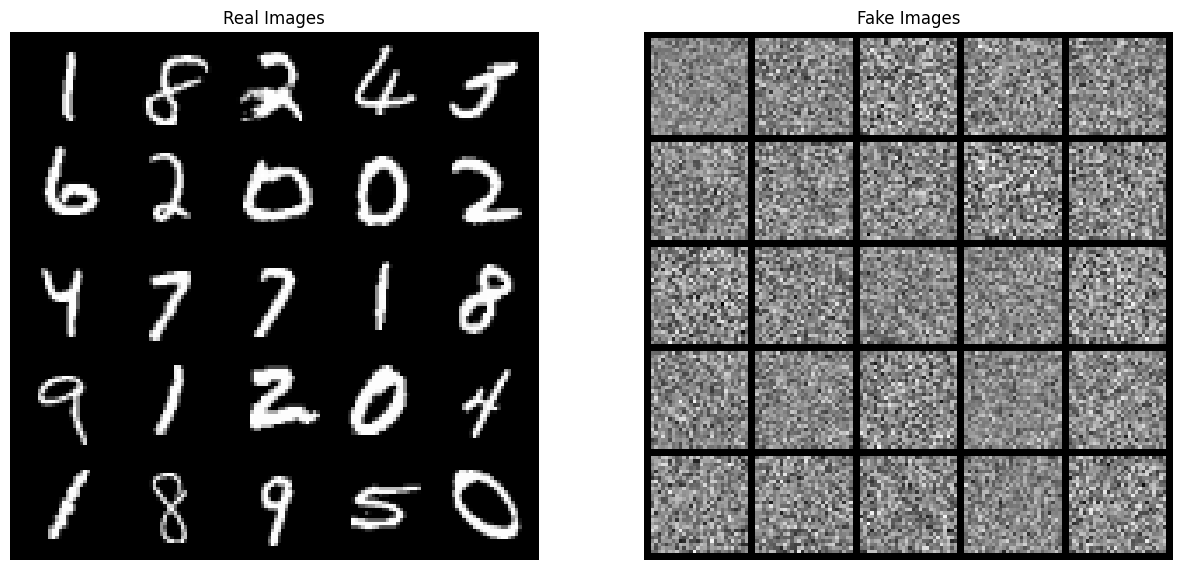

[Epoch: 0/100] | [Step: 100/46900] Generator Loss: 1.8628356233239174, Discriminator Loss: 0.23602866218425333
[Epoch: 0/100] | [Step: 200/46900] Generator Loss: 2.298149785026908, Discriminator Loss: 0.19543087983038276
[Epoch: 0/100] | [Step: 300/46900] Generator Loss: 4.421781115233898, Discriminator Loss: 0.061718884186120704


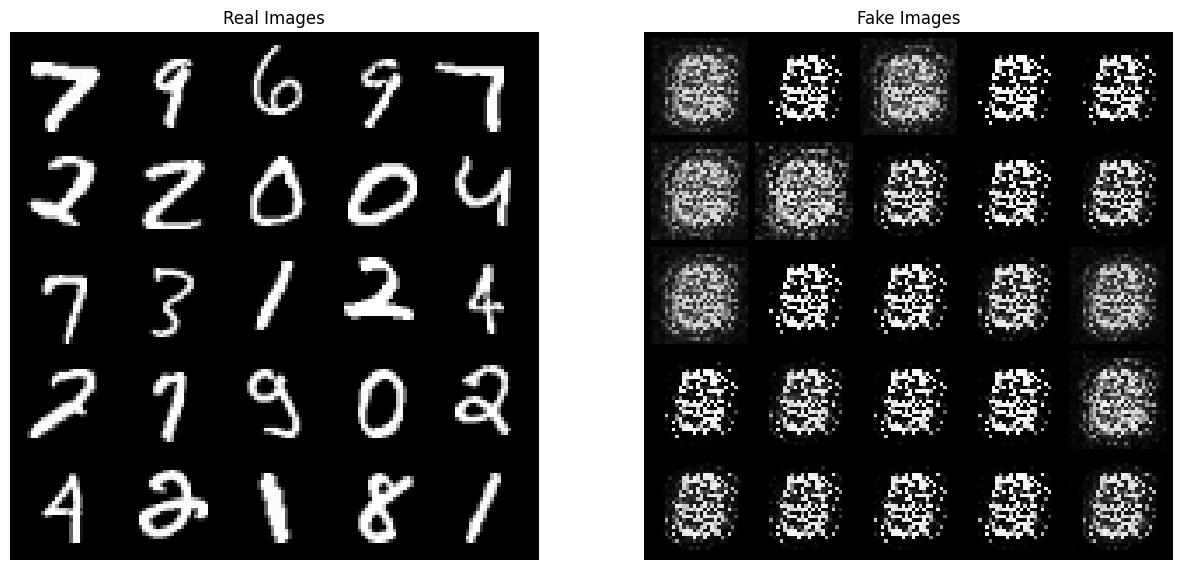

[Epoch: 0/100] | [Step: 400/46900] Generator Loss: 7.101132858544588, Discriminator Loss: 0.11094787155161612


  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 1/100] | [Step: 500/46900] Generator Loss: 3.041323992113272, Discriminator Loss: 0.11679179518250749
[Epoch: 1/100] | [Step: 600/46900] Generator Loss: 3.364603441208601, Discriminator Loss: 0.0908125352289062


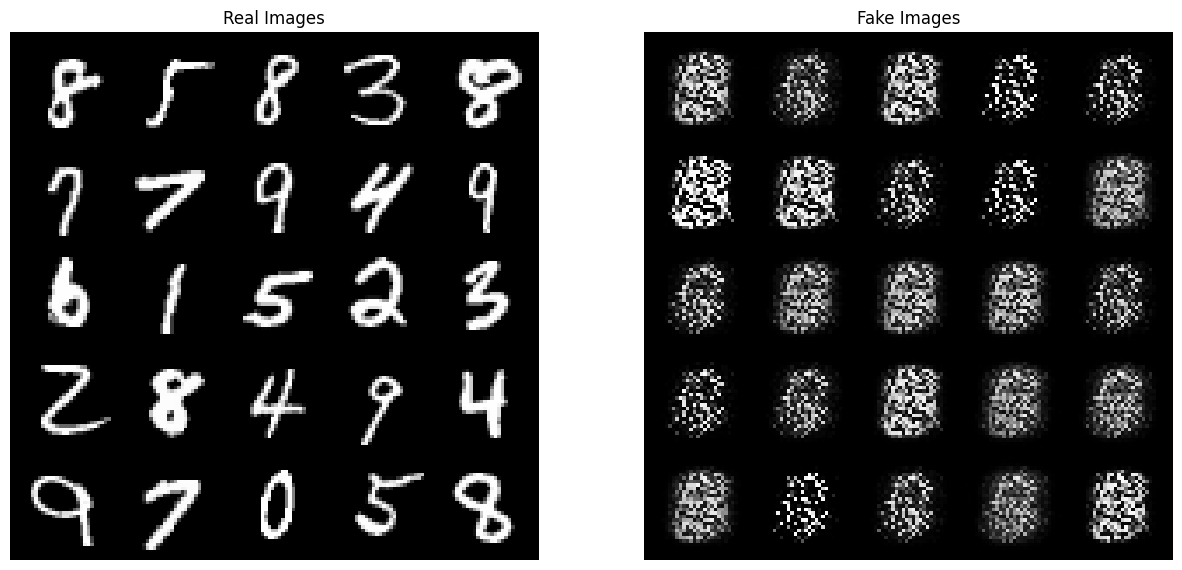

[Epoch: 1/100] | [Step: 700/46900] Generator Loss: 3.0129128452390432, Discriminator Loss: 0.04921332630328834
[Epoch: 1/100] | [Step: 800/46900] Generator Loss: 2.8213245198130608, Discriminator Loss: 0.04648444670601748
[Epoch: 1/100] | [Step: 900/46900] Generator Loss: 2.9306838680058718, Discriminator Loss: 0.06759631526074372


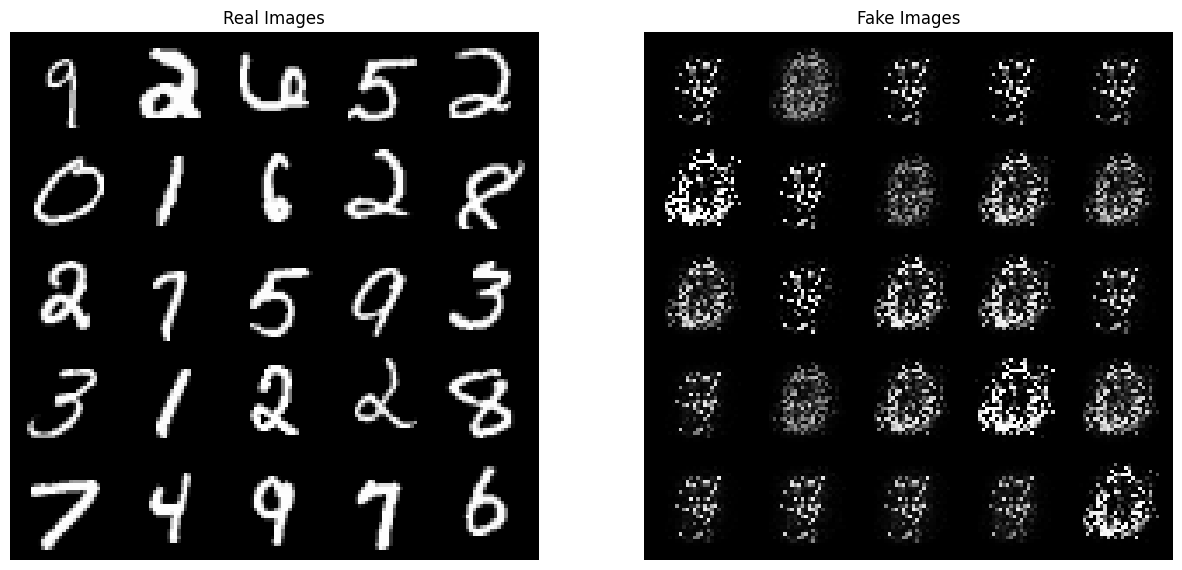

  0%|          | 0/469 [00:00<?, ?it/s]

[Epoch: 2/100] | [Step: 1000/46900] Generator Loss: 3.4326829115549726, Discriminator Loss: 0.06479560824421544


KeyboardInterrupt: ignored

In [19]:
# Training Loop
DISPLAY_STEP = 100
TOTAL_STEPS = NUM_EPOCHS*len(train_loader)

image_show = []

# for visualizing development after training
generator_losses = []
discriminator_losses = []
current_step = 0

mean_generator_loss = 0
mean_discriminator_loss = 0
start_time = time.time()

epoch: int
for epoch in range(NUM_EPOCHS):

  for real_images, _ in tqdm(train_loader):  # real_images: [128, 1, 28, 28]

    # batch size might be different than BATCH_SIZE in the last of an epoch's batches
    current_batch_size = len(real_images)

    # create new tensor with the same data but of a different shape (cf. np.squeeze())
    real_images_flattened = real_images.view(current_batch_size, -1).to(DEVICE)  # <class 'torch.Tensor'> of size torch.Size([128, 784])

    # generated fake images
    noise = get_generator_noise(n_sample=current_batch_size,
                                z_dim=Z_DIM,
                                device=DEVICE)  # <class 'torch.Tensor'> of size torch.Size([128, 64]).
    # execute the model’s forward(), along with some background operations
    fake_images_flat = generator(noise)  # [128, 784]

    #-----------
    # train discriminator
    #-----------
    # set the gradients of all optimized torch.Tensors to zero.
    disc_optimizer.zero_grad()
    discriminator_loss = get_discriminator_loss(
                                       discriminator=discriminator,
                                       criterion=criterion,
                                       fake_images_flat=fake_images_flat,
                                       real_images_flattened=real_images_flattened)  # <class 'torch.Tensor'> of size torch.Size([])
    # compute the gradient of current tensor w.r.t. graph leaves.
    discriminator_loss.backward()
    # perform a single optimization step (parameter update).
    disc_optimizer.step()

    #-----------
    # train generator
    #-----------
    # set the gradients of all optimized torch.Tensors to zero.
    gen_optimizer.zero_grad()
    generator_loss = get_generator_loss(
                                  discriminator=discriminator,
                                  criterion=criterion,
                                  fake_images_flat=fake_images_flat)  # <class 'torch.Tensor'> of size torch.Size([]).
    # compute the gradient of current tensor w.r.t. graph leaves.
    generator_loss.backward()
    # perform a single optimization step (parameter update).
    gen_optimizer.step()

    mean_discriminator_loss += discriminator_loss.item() / current_batch_size  # <class 'float'> with content 0.001509111374616623.
    mean_generator_loss += generator_loss.item() / current_batch_size  # <class 'float'> with content 0.019790537655353546.

    generator_losses.append(mean_generator_loss)
    discriminator_losses.append(mean_discriminator_loss)

    if (current_step % DISPLAY_STEP == 0) or (current_step == TOTAL_STEPS - 1):

      # remember fake images for the image show below
      image_show.append(make_grid(fake_images_flat.detach().cpu().view(-1, *IMAGE_SIZE)[:36], nrow=6, normalize=True, padding=2))

      print(f"[Epoch: {epoch}/{NUM_EPOCHS}] | [Step: {current_step}/{TOTAL_STEPS}]",
            f"Generator Loss: {mean_generator_loss}, "
            f"Discriminator Loss: {mean_discriminator_loss}")

      mean_discriminator_loss = 0
      mean_generator_loss = 0

      # every n steps, live display 25 real and 25 generated images
      if (current_step % (DISPLAY_STEP * 3) == 0) or (current_step == TOTAL_STEPS - 1):
          show_tensor_images(real_images_flattened=real_images_flattened,
                             fake_images_flat=fake_images_flat)

    current_step += 1


end = time.time() - start_time
print('time for train: ', end/3600 , 'hours')

## Visualization

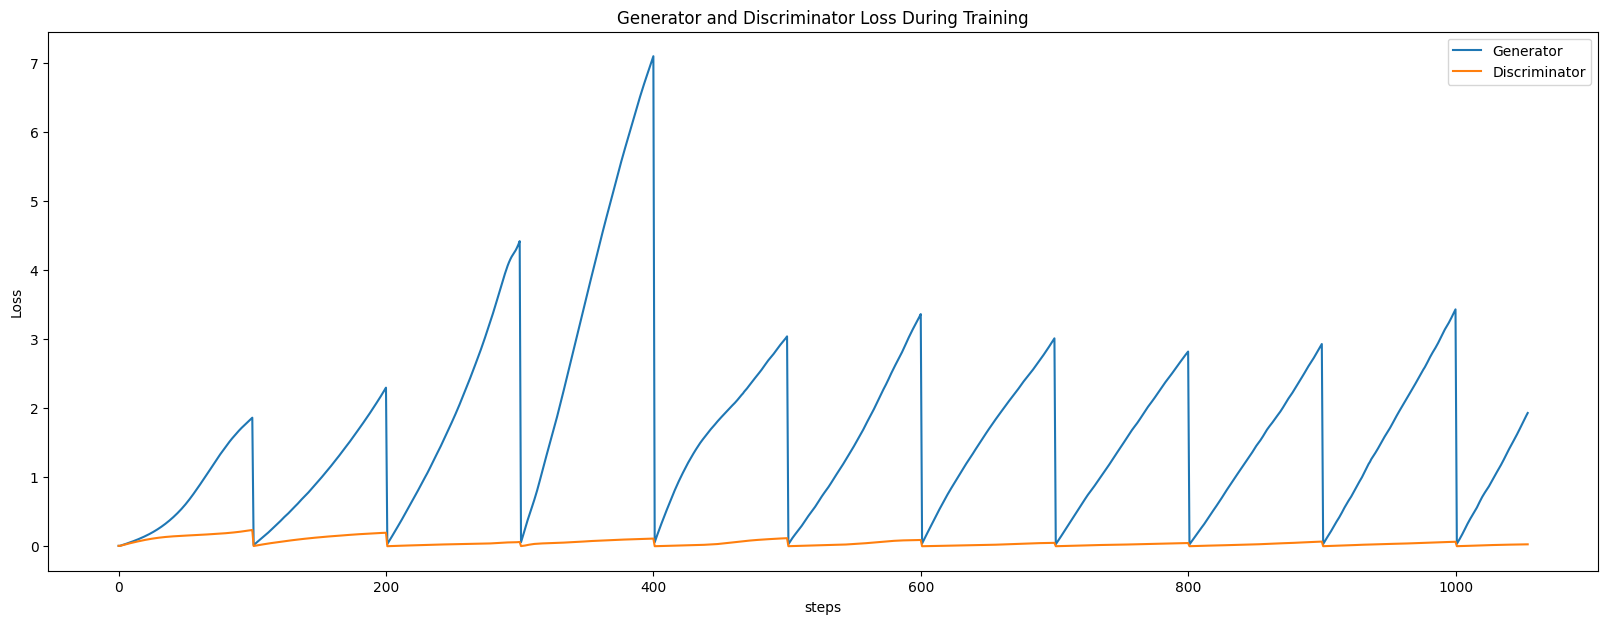

In [20]:
plt.figure(figsize=(20, 7))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses, label="Generator")
plt.plot(discriminator_losses, label="Discriminator")
plt.xlabel("steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

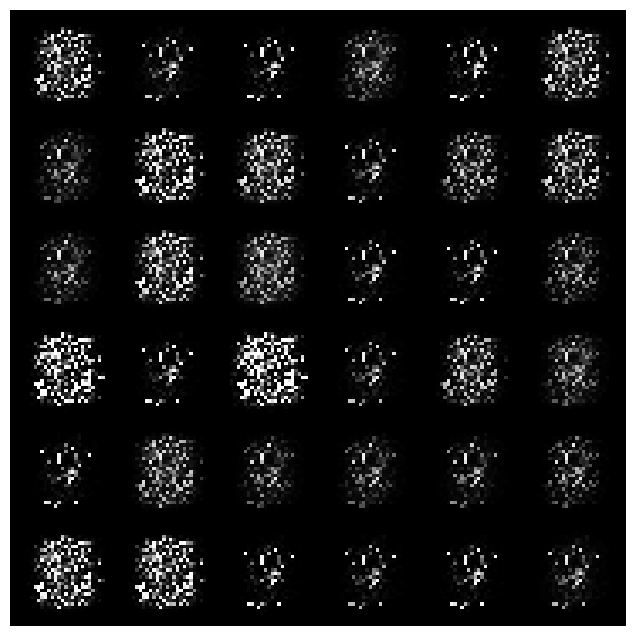

In [21]:
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
imgs = [[plt.imshow(np.transpose(img, (1,2,0)), animated=True)] for img in image_show]
anim = animation.ArtistAnimation(fig, imgs, interval=100, repeat_delay=1000, blit=True)

HTML(anim.to_jshtml())